# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from BSMBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

SNR = 30 # dB

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = False)

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.994511772806547


# Visualize Generated Sources and Mixtures

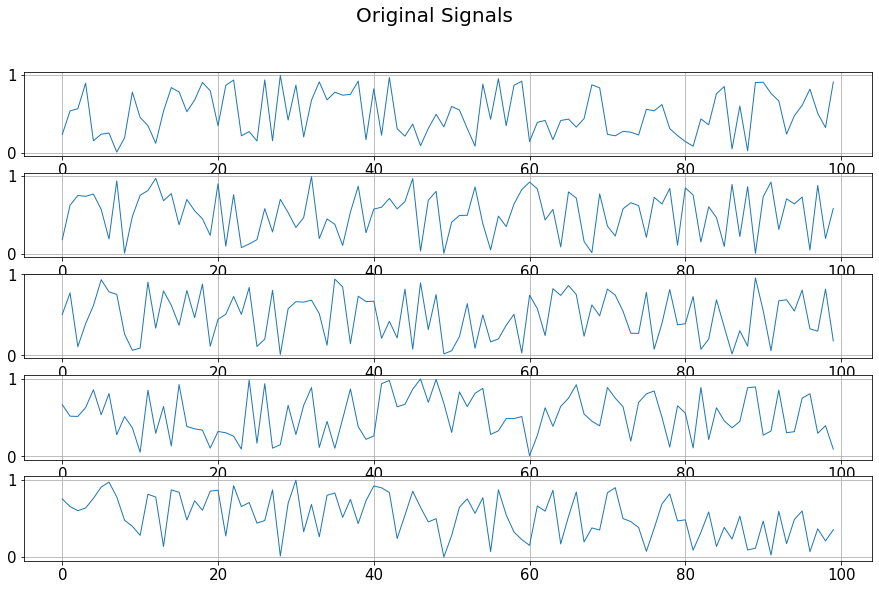

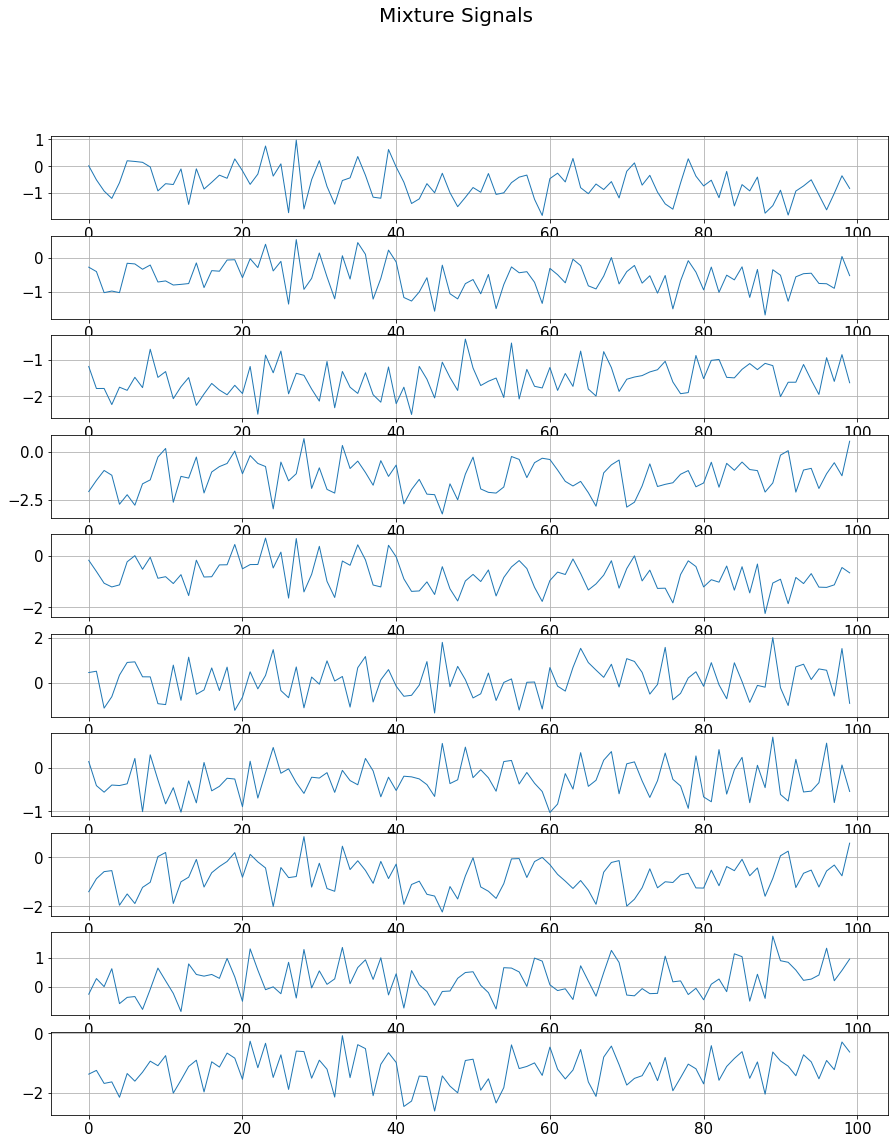

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
debug_iteration_point = 25000
gamma = np.sqrt(1 - 1e-3)
W = np.eye(NumberofSources)
M = 0.1*np.eye(NumberofSources)

# Run BSM Algorithm on Mixture Signals

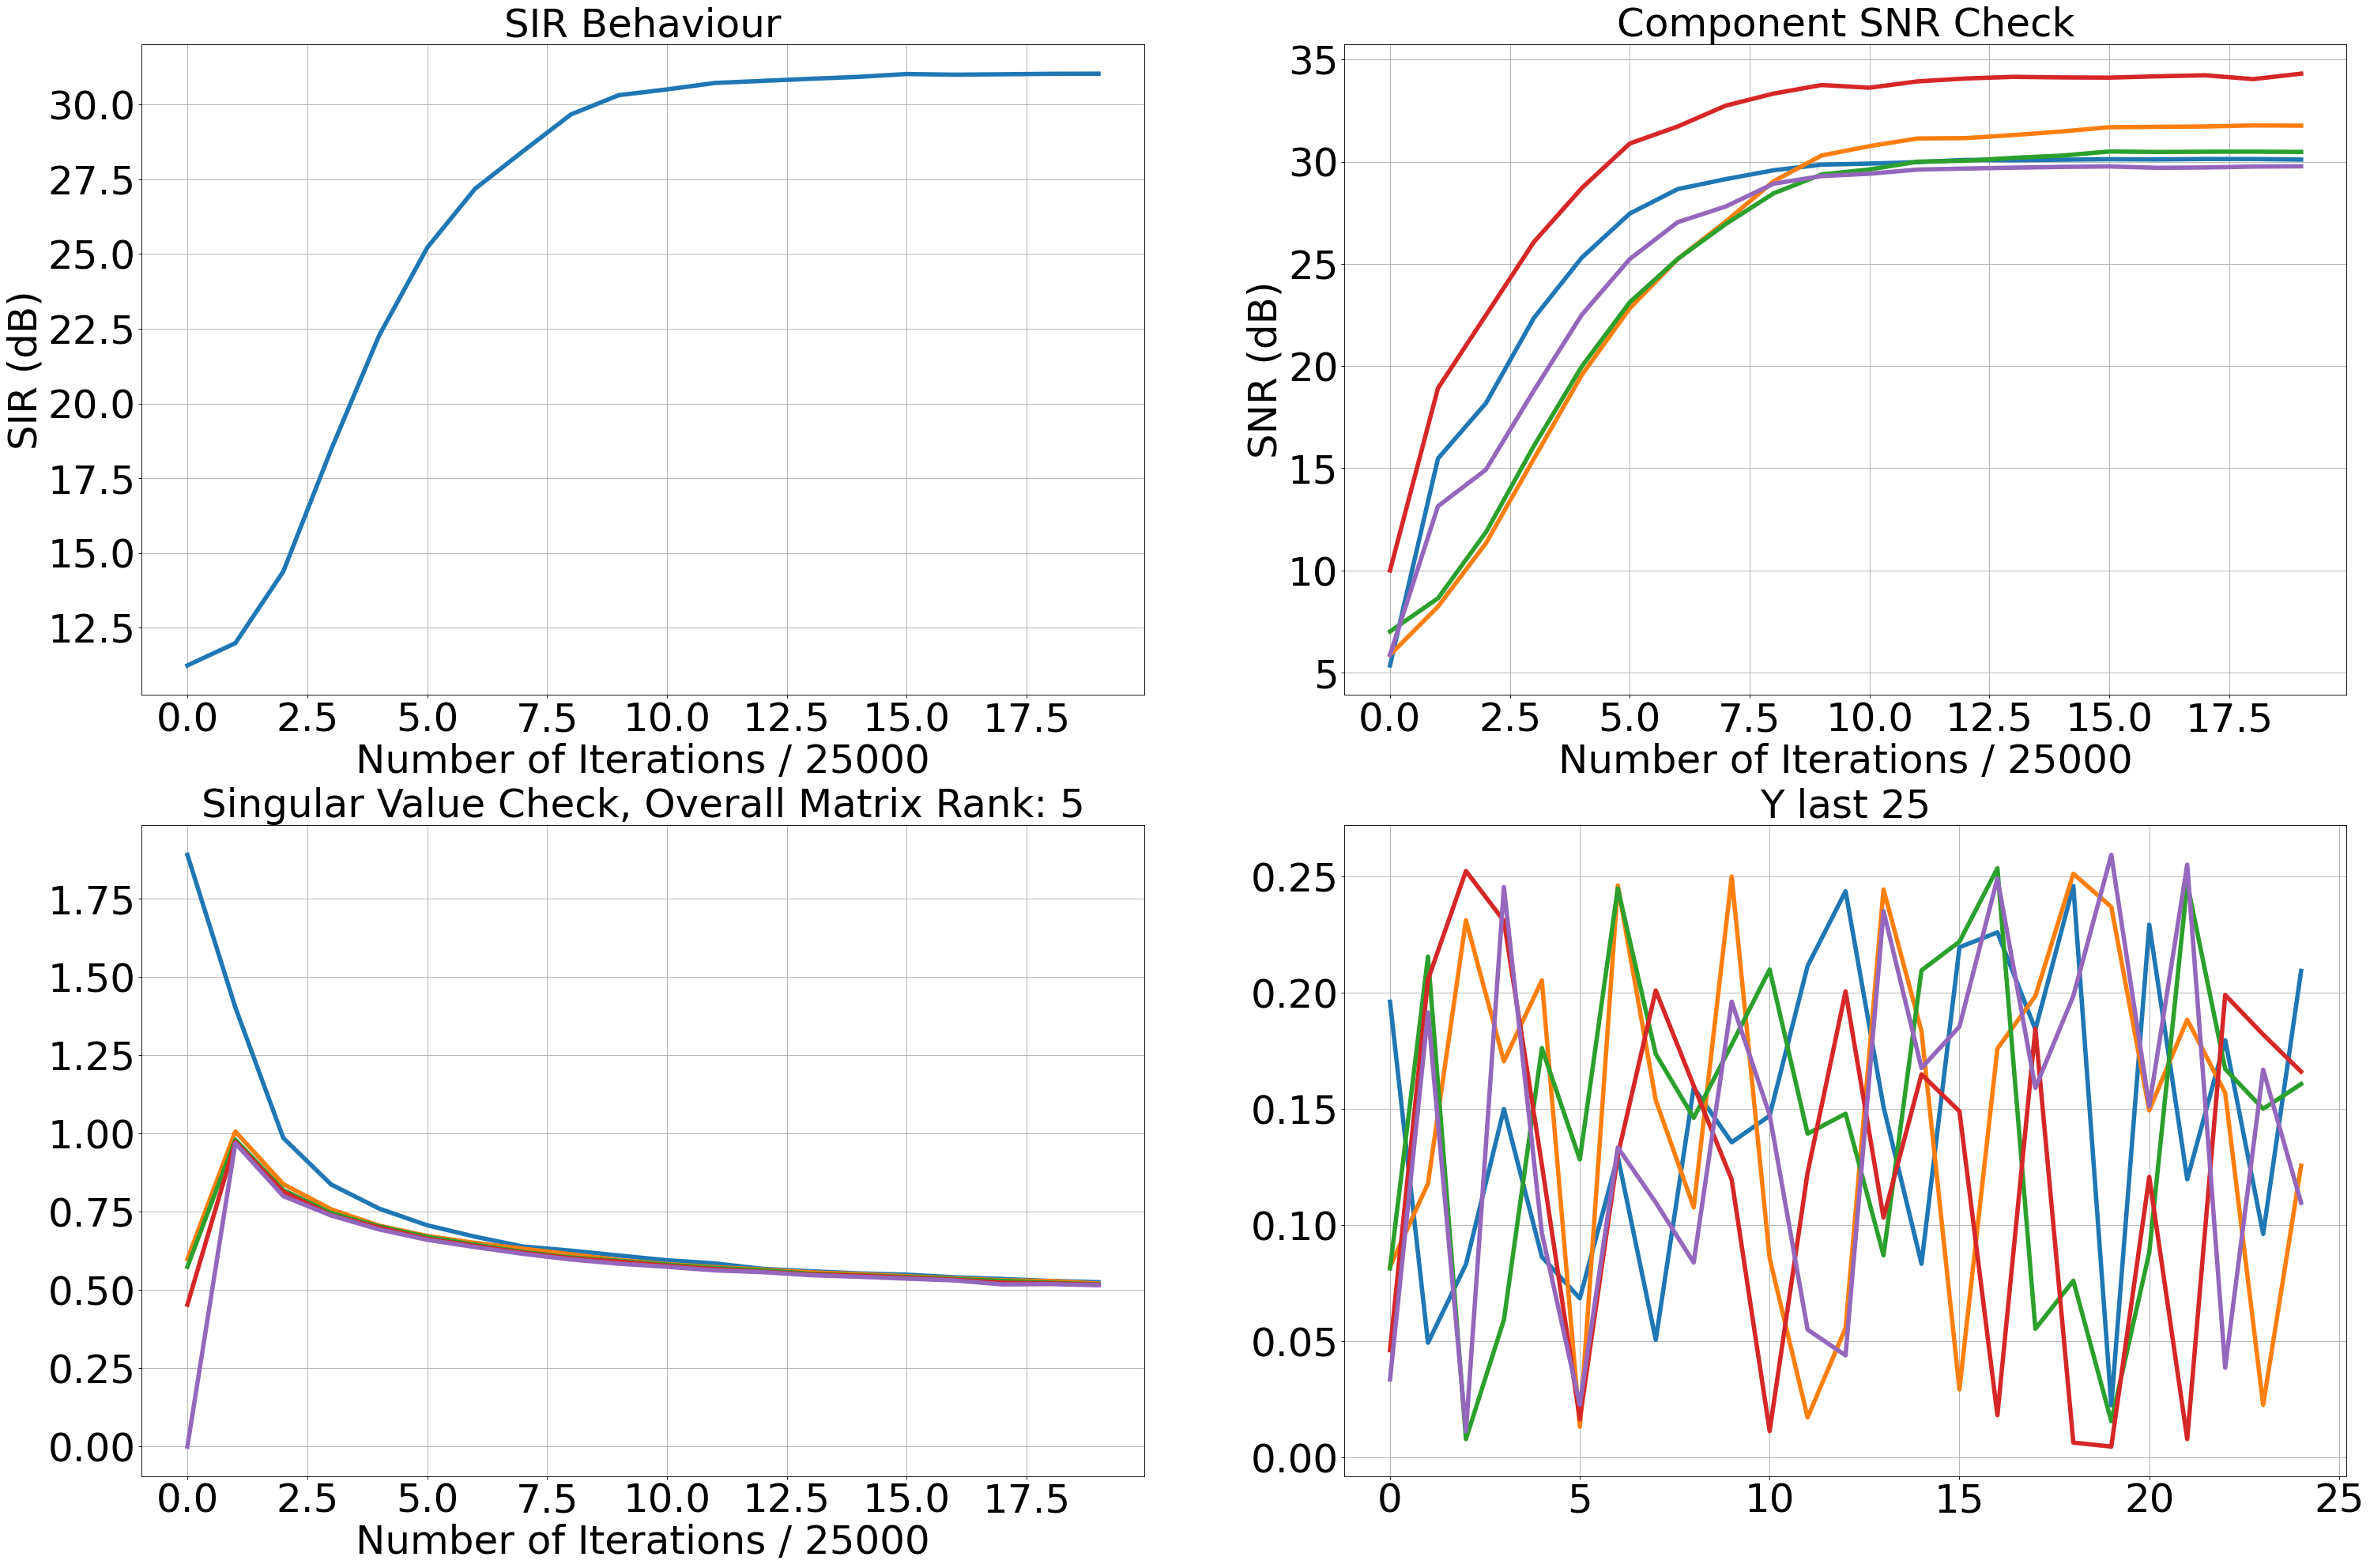

100%|██████████| 500000/500000 [01:33<00:00, 5366.01it/s] 


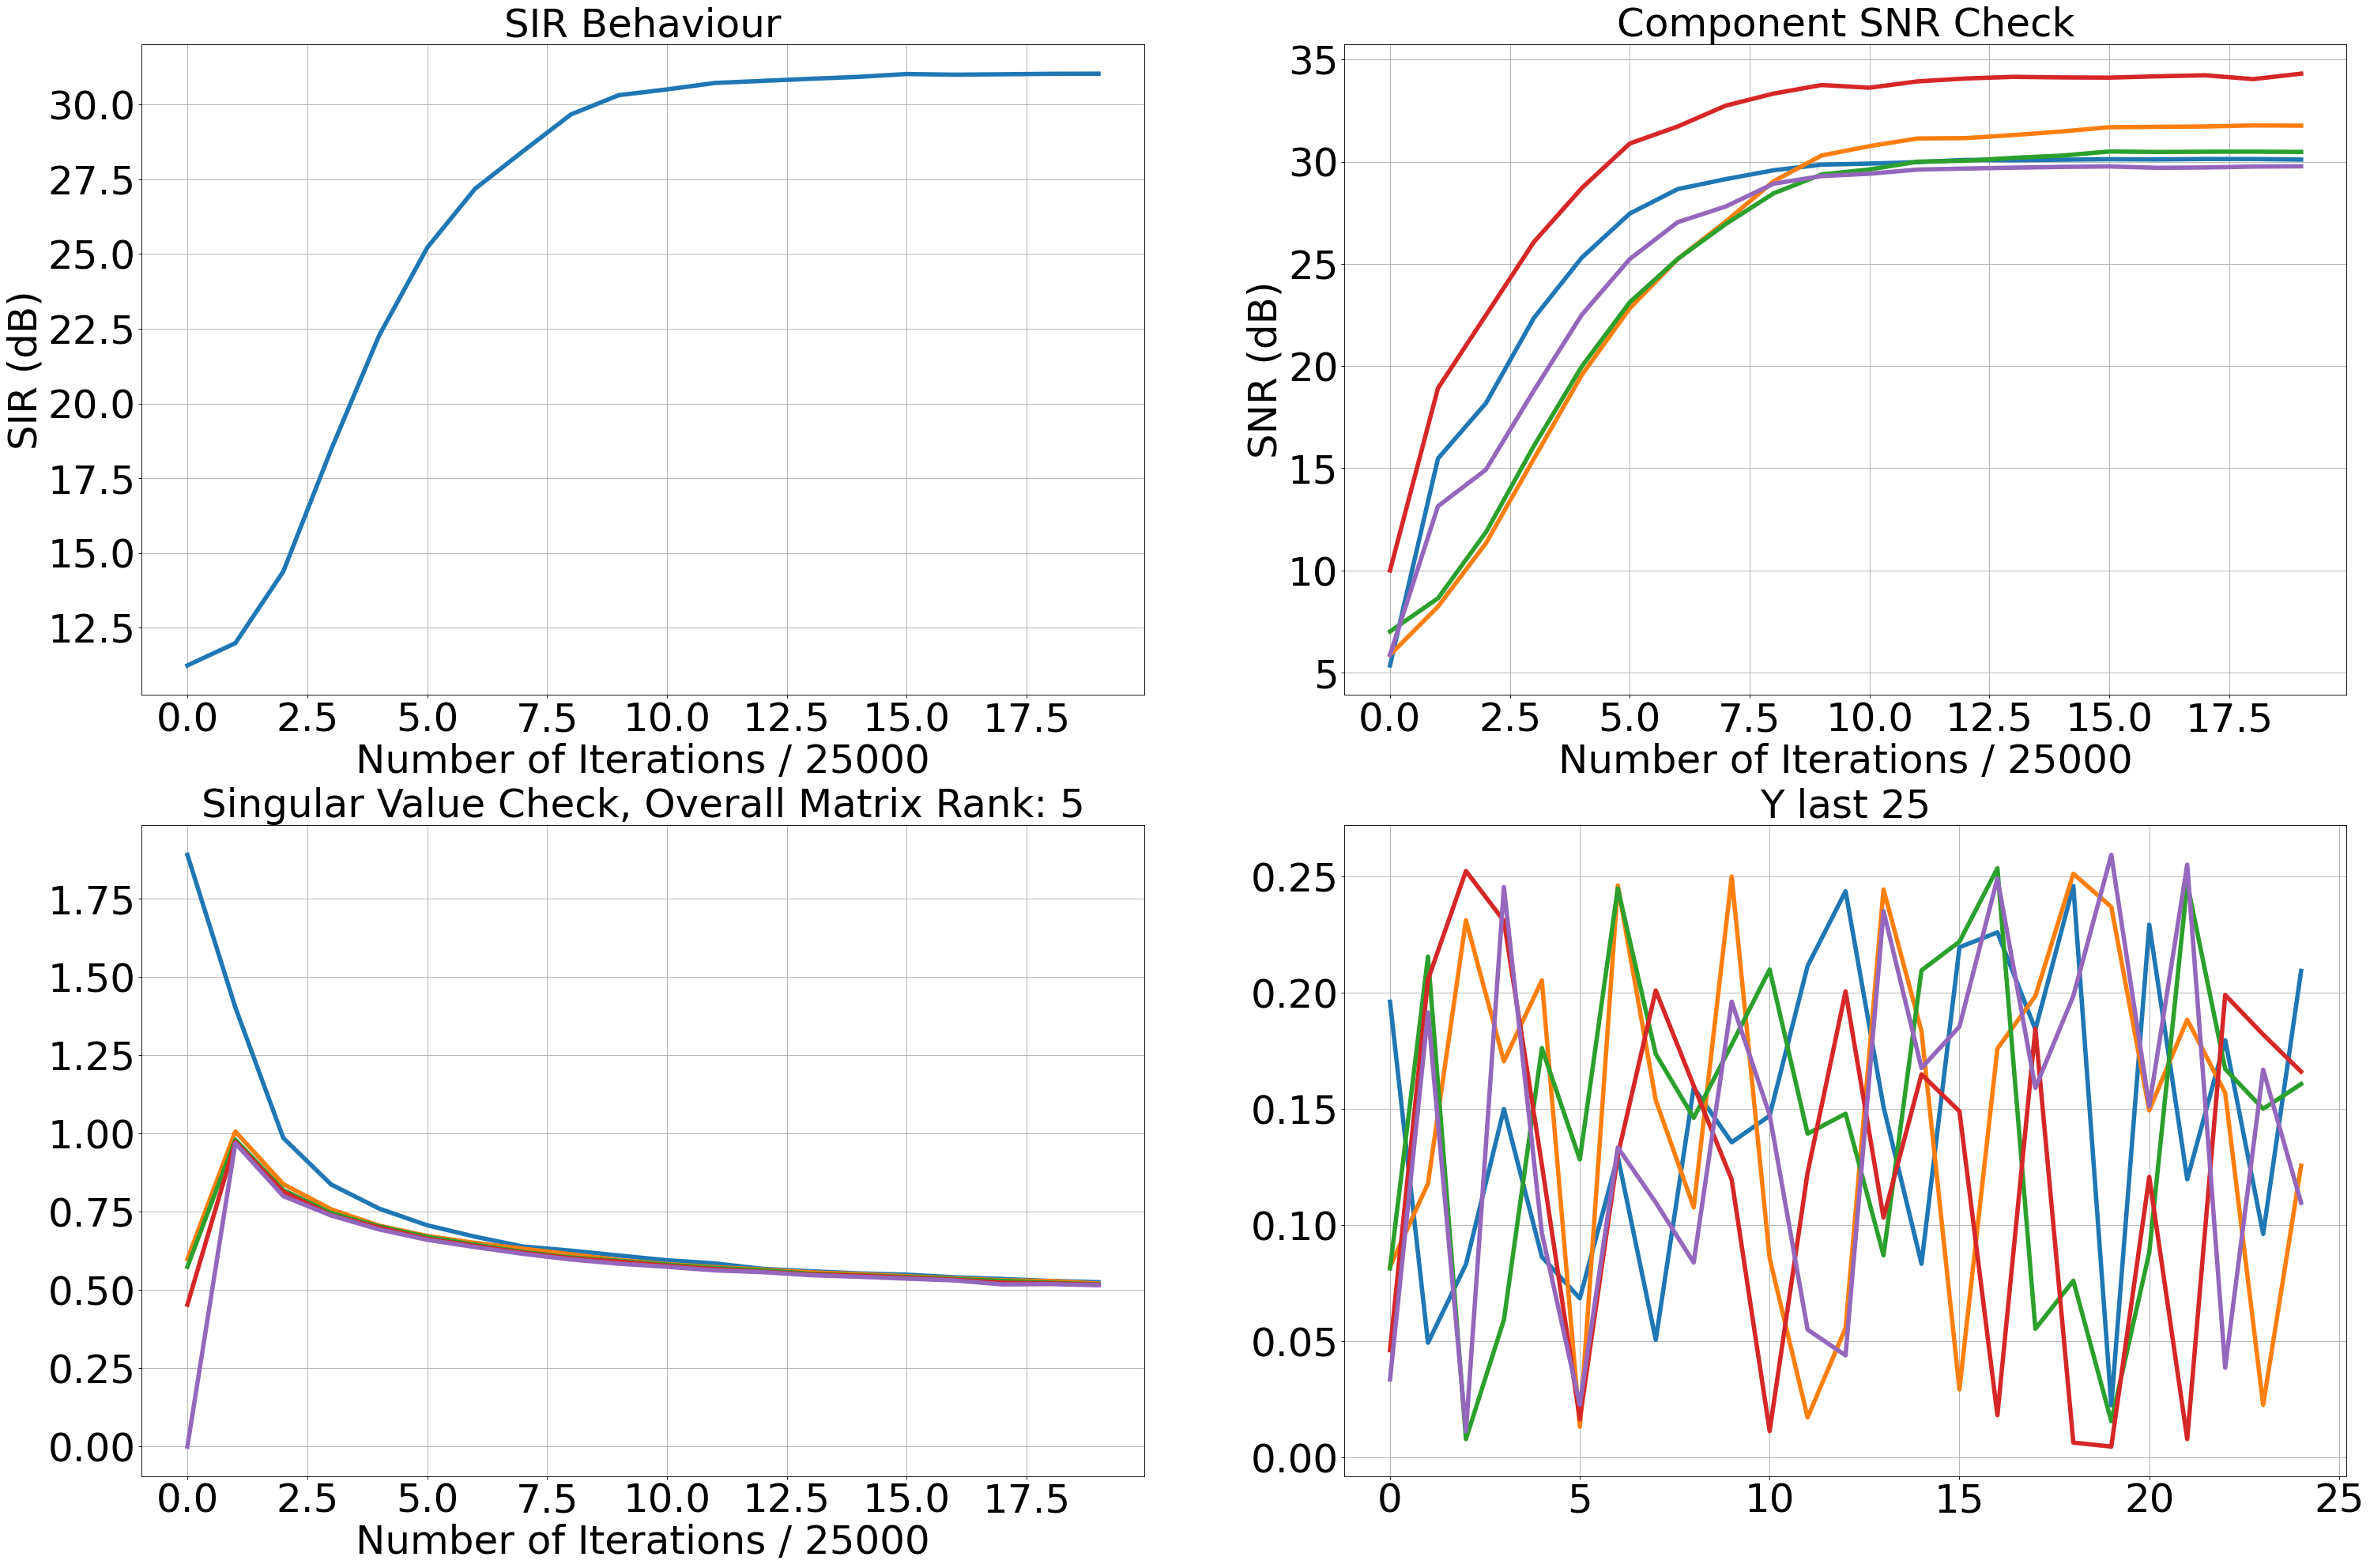

In [6]:
model = OnlineBSM(s_dim = NumberofSources, x_dim = NumberofMixtures, beta = 1e-6, 
                  gamma = gamma, whiten_input_ = True,
#                   W = W, M = M,
                  neural_OUTPUT_COMP_TOL = 1e-7,
                  set_ground_truth = True, S = S, A = A)

model.fit_batch_nnantisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 1,
                             neural_lr_start = 1.5, neural_lr_stop = 1e-4, 
                             fast_start = True, debug_iteration_point = debug_iteration_point,
                             plot_in_jupyter = True)

# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Wf = model.compute_overall_mapping(return_mapping = True)
# Wf = np.linalg.pinv(M * D.T) @ W @ model.Wpre
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [30.12760925 31.76821114 30.50706083 34.21445754 29.7789155 ]

Overall SINR : 31.045321226418935


# Vizualize Extracted Signals Compared to Original Sources

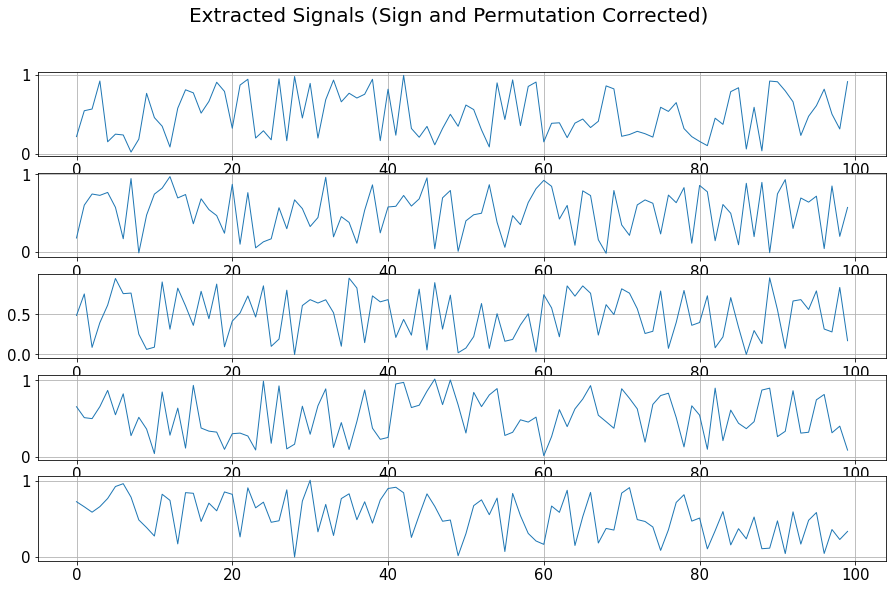

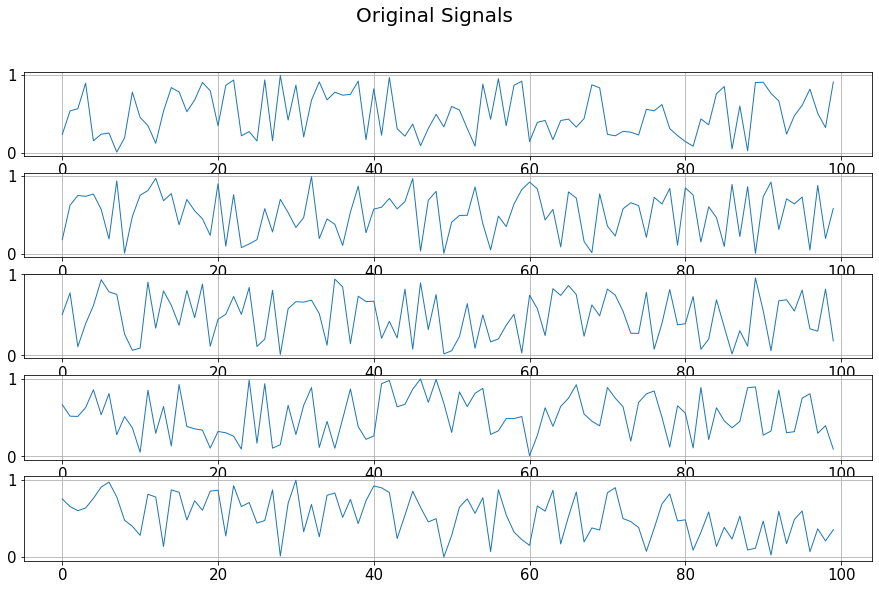

In [8]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)